<a href="https://colab.research.google.com/github/ChloeMorgana/Dissertation-Project/blob/main/PubMedBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading of DrugProt dataset

Downloading and unzipping file

In [35]:
!wget https://zenodo.org/record/5042151/files/drugprot-gs-training-development.zip
!unzip drugprot-gs-training-development.zip

--2023-01-25 11:10:17--  https://zenodo.org/record/5042151/files/drugprot-gs-training-development.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3796908 (3.6M) [application/octet-stream]
Saving to: ‘drugprot-gs-training-development.zip.2’

drugprot-gs-trainin 100%[===================>]   3.62M  1.58MB/s    in 2.3s    

2023-01-25 11:10:21 (1.58 MB/s) - ‘drugprot-gs-training-development.zip.2’ saved [3796908/3796908]

Archive:  drugprot-gs-training-development.zip
replace drugprot-gs-training-development/README.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Combining all three files together.

In [128]:
def loadDrugProt(abstracts_filename, entities_filename, relations_filename):

  docs = {}

  # Load the title/abstracts text in as documents
  with open(abstracts_filename, encoding='utf8') as f:
    for lineno,line in enumerate(f):
      split = line.strip('\n').split('\t')
      assert len(split) == 3, f"Expected 3 columns but got {len(split)} on line {lineno+1}"
      pubmed_id, title, abstract = split
      pubmed_id = int(pubmed_id)

      combined_text = title + '\n' + abstract
      docs[pubmed_id] = {'pubmed_id':pubmed_id, 'text':combined_text, 'entities':{}, 'relations':[]}

  # Load the entities and match them up with the documents
  with open(entities_filename, encoding='utf8') as f:
    for lineno,line in enumerate(f):
      split = line.strip('\n').split('\t')
      assert len(split) == 6, f"Expected 6 columns but got {len(split)} on line {lineno+1}"
      pubmed_id, entity_id, entity_type, start_coord, end_coord, entity_text = split

      pubmed_id = int(pubmed_id)
      start_coord = int(start_coord)
      end_coord = int(end_coord)

      assert pubmed_id in docs, f"Did not find matching document for pubmed_id={pubmed_id}"
      doc = docs[pubmed_id]

      assert doc['text'][start_coord:end_coord] == entity_text, f"Text for entity with coords {start_coord}:{end_coord} in document (pubmed_id={pubmed_id} does not match expected. 'f{doc['text'][start_coord:end_coord]}' != '{entity_text}'"

      entity = {'type':entity_type, 'start':start_coord, 'end':end_coord, 'text':entity_text}
      doc['entities'][entity_id] = entity

  if relations_filename is not None:
    # Load the relations and match them up with the entities in the corresponding document
    with open(relations_filename, encoding='utf8') as f:
      for lineno,line in enumerate(f):
        split = line.strip('\n').split('\t')
        assert len(split) == 4, f"Expected 4 columns but got {len(split)} on line {lineno+1}"

        pubmed_id, relation_type, arg1, arg2 = split

        pubmed_id = int(pubmed_id)
        assert arg1.startswith('Arg1:'), f"Relation argument should start with 'Arg1:'. Got: {arg1}"
        assert arg2.startswith('Arg2:'), f"Relation argument should start with 'Arg2:'. Got: {arg2}"

        # Remove arg1/arg2 from text
        arg1 = arg1.split(':')[1]
        arg2 = arg2.split(':')[1]

        assert pubmed_id in docs, f"Did not find matching document for pubmed_id={pubmed_id}"
        doc = docs[pubmed_id]

        assert arg1 in doc['entities'], f"Couldn't find entity with id={arg1} in document with pubmed_id={pubmed_id}"
        assert arg2 in doc['entities'], f"Couldn't find entity with id={arg2} in document with pubmed_id={pubmed_id}"

        relation = {'type':relation_type,'arg1':arg1,'arg2':arg2}
        doc['relations'].append(relation)

  # Convert the dictionary of documents (indexed by pubmed_id) into a simpler dictionary
  docs = sorted(docs.values(), key=lambda x:x['pubmed_id'])

  return docs

Applying function to dataset

In [129]:
docs = loadDrugProt('drugprot-gs-training-development/training/drugprot_training_abstracs.tsv',
                    'drugprot-gs-training-development/training/drugprot_training_entities.tsv',
                    'drugprot-gs-training-development/training/drugprot_training_relations.tsv')

dev_docs = loadDrugProt('drugprot-gs-training-development/development/drugprot_development_abstracs.tsv',
                    'drugprot-gs-training-development/development/drugprot_development_entities.tsv',
                    'drugprot-gs-training-development/development/drugprot_development_relations.tsv')

Observation of doc structure


In [130]:
search = [ d for d in docs if d['pubmed_id'] == 23197773]
assert len(search) == 1, "Something went wrong and couldn't find the document we want"


#non_sent = [ d for d in docs if d['pubmed_id'] == 8733007]
docs.remove(search[0])

We can observe the total number of relations and the number of different relation types across all documents below:

# Encoding Step

The code below imports certain packages that will be used during this relation extraction task.

In [131]:
#!pip install torch
!pip install transformers
!pip install segtok

#import transformers as ppb
from transformers import BertModel, AutoTokenizer
import pandas as pd
import numpy as np
import nltk
import torch
import itertools
from segtok.segmenter import split_single

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


This is a function that checks if a particular entity tag is part of a relation or not. This is used to form labels for the data so that the classifier can learn which sentences contain relations and which do not.

In [158]:
#Checks if both arguments are terms in one relation
def isRelation(arg1,arg2,doc):
  relation = 0
  for r in doc['relations']:
    if (arg1 == r['arg1']) and (arg2 == r['arg2']):
      return r['type']
  return "None"

This function takes in the text and finds all of the labels for all pairs of entity relations. This will be used later to input into the classifier.

In [178]:
# This finds the indexes of the start and end of sentences and returns them in a list.
def find_sent_idxs(text):
  idxs = [0]
  idx = 0

  split_text = split_single(text)
  for t in split_text:
    idx += len(t)+1
    idxs.append(idx)
  return idxs


def find_entity_labels(idxs, keys, doc):
  labels = []
  sentences= []
  entity_dict = {}

  for i in idxs:
    entity_dict[i]=[]

  for key in keys:
    for i in range(len(idxs)-1):
      s = doc['entities'][key]['start']
      e = doc['entities'][key]['end']
        
      # If the start and end indexes appear within one sentence, add the starting index to the dictionary.
      if (s >= idxs[i] and s < idxs[i+1]) and (e > idxs[i] and e <= idxs[i+1]):
        entity_dict[idxs[i]].append(key)
      
  # For every key in the dictionary, if there is a list of values, go through them and append them to a list of chemicals or genes depending on which one it is.
  for k, v in entity_dict.items():
    if not v==[]:
        
      chems = [value for value in v if doc['entities'][value]['type'] == 'CHEMICAL']
      genes = [value for value in v if doc['entities'][value]['type'] != 'CHEMICAL']
        
      # Find the cartesian product of these entities
      # If both of the entities are part of a relation, add a positive label (1), else add a negative label (0)
      prods = itertools.product(chems,genes)
      
      for prod in prods:
        str = ''
        index = k
        end_idx = idxs[idxs.index(k)+1]
        
        #Makes sure the indices of these mentions are in order
        key_list = sorted(prod, key= lambda x: (doc['entities'][x]['start']))
        
        for key in key_list:
            start = doc['entities'][key]['start']
            end = doc['entities'][key]['end']
            name = doc['text'][start:end]
            name = name.replace('.', ' ')

            if doc['entities'][key]['type'] == 'CHEMICAL':
                str += doc['text'][index:start] + ' [E1] ' + name + ' [/E1]'
            else:
                str += doc['text'][index:start] + ' [E2] ' + name + ' [/E2]'
            index = end
        str+=doc['text'][end:end_idx]

        #Adding the tagged sentence to the list of sentences
        sentences.append(str)
        
        # Adding the labels to the list
        labels.append(isRelation(prod[0],prod[1],doc))

  return labels, sentences

This function adds in start and end entity tags to biomedical text. This ensures that every chemical mentioned is encased in [E1][/E1] tags, and every gene is encased in [E2][/E2] tags, so that we can extract the embeddings for these later.

In [183]:
def addEntityTags(d):
    
  sentences = []
  labels = []
  
  for doc in d:
        
    str = ''
    index = 0

    #Contains every mention of chemicals and genes for a particular document
    keys = doc['entities'].keys()

    #Finds the indexes of the start and end of each sentence in the text
    idxs = find_sent_idxs(doc['text'])
    
    labs,sent = find_entity_labels(idxs, keys, doc)
    
    labels+=labs
    sentences+=sent
    
  return sentences, labels

doc_sent, doc_lab = addEntityTags(docs)
dev_doc_sent, dev_doc_lab = addEntityTags(dev_docs)

print(len(doc_sent))
print(len(doc_lab))

print()
print(len(dev_doc_sent))
print(len(dev_doc_lab))


64685
64685

13396
13396


Next, we can reduce the text to only sentences potentially containing relations between chemicals and genes by splitting the sentences and seeing if there are any entity tags present within the sentence. The findLabels function goes through the list of labels for a particular document and sees if there is a relation present within that sentence.

(Note for later: I didn't take into account relations across sentences in this implementation, will have to change something to ensure that both entities for one relation are in the same sentence)

# Embedding Step

Next, a BERT model is defined that has been pre-trained using PubMed texts. This allows BERT to recognise biomedical terms within the text and understand their context better.

The tokeniser is also defined using pubmed texts, and special tokens are added in so that BERT can recognise them and not break them down when tokenising.

In [136]:
model = BertModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                                  output_hidden_states = True,
                                  attention_probs_dropout_prob=0.1,
                                  hidden_dropout_prob=0.1
                                  )

#print(model)

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext") 

tokenizer.add_tokens(["[E1]", "[/E1]", "[E2]", "[/E2]"])

tokenizer.vocab["[E1]"]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30522

This function adds [CLS] and [SEP] tokens to the beginning and end of sentences so that BERT knows when a new sentence is beginning. It then tokenises these sentences and converts all of the inputs into tensors.

In [184]:
def bert_text_prep(text, tokenizer):

  #CLS lets BERT know when start of sentence begins, SEP indicates start of second sentence.
  marked_text = "[CLS]" + text + "[SEP]"

  #Tokenizes text
  tokenized_text = tokenizer.tokenize(marked_text)

  #Converts to ids
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1]*len(indexed_tokens)

  # Converts inputs to tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  
  segments_tensors = torch.tensor([segments_ids])

  return tokenized_text, tokens_tensor, segments_tensors

These tensors are then used to find the embeddings of all of the tokens.

In [189]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2][1:]

  token_embeddings = hidden_states[-1]

  #Collapsing tensor into 1 dimension
  token_embeddings = torch.squeeze(token_embeddings, dim=0)
  
  #converting tensors to lists
  list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

  return list_token_embeddings

In order to find the relevant embeddings (entity start tag embeddings), findTags looks through the tokenised sentence and adds the index of that particular tag into a list of chemical indices or gene indices.

These are then used after the sentence has been converted into embeddings to find the embedding at these specific indexes. The embeddings are accompanied by the cartesian product of all of the chemical and gene entities found, so that the embeddings for the specified indexes are concatenated.

In [188]:
def findEmbedding(tokens, embeddings):
    chem = tokens.index('[e1]')
    gene = tokens.index('[e2]')
    
    #Returns empty lists if either chemicals or genes aren't present
    return embeddings[chem]+embeddings[gene]

Getting CLS and entity embeddings for each sentence



In [ ]:
def get_embeddings(target_text):
  cls_embeddings = []
  entity_embeddings = []

  for text in target_text:

      #Finds tokenized text and tensors for a particular sentence in a document
      tokenized_text, tokens_tensor, segments_tensor = bert_text_prep(text, tokenizer)

      #Finds the embeddings
      list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensor, model)

      #Adds the [CLS] token embedding to the list
      cls_embeddings.append(list_token_embeddings[0])

      #Finds the indexes for chemicals and genes in the sentence
      entity_embeddings.append(findEmbedding(tokenized_text, list_token_embeddings))

  return cls_embeddings, entity_embeddings

cls_embeddings, entity_embeddings = get_embeddings(doc_sent)
dev_cls, dev_ent = get_embeddings(dev_doc_sent)

# Saving training set embeddings to files
np.save("cls_embeddings.npy",cls_embeddings)
np.save("entity_embeddings.npy",entity_embeddings)

# Saving development set embeddings to files
np.save("dev_cls_embeddings.npy",dev_cls)
np.save("dev_ent_embeddings.npy",dev_ent)


In [195]:
cls_embeddings = np.load("cls_embeddings.npy")
entity_embeddings = np.load("entity_embeddings.npy")

dev_cls = np.load("dev_cls_embeddings.npy")
dev_ent = np.load("dev_ent_embeddings.npy")

print(len(cls_embeddings))
print(len(entity_embeddings))

print(len(dev_cls))
print(len(dev_ent))


13103
13103
2723
2723


In [ ]:
print(len(docs))

## Classification Step

Relevant imports:



In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

Classifying these using logistic regression

In [148]:
#Splits the sentences into training and test sets for binary classification
#cls_train_features, cls_test_features, cls_train_labels, cls_test_labels = train_test_split(cls_embeddings, labels)

#Defines a logistic regression classifier
lr_clf = LogisticRegression(solver='saga', class_weight = 'balanced')

#Fits the model to the training data
#lr_clf.fit(cls_train_features, cls_train_labels)
lr_clf.fit(cls_embeddings, labels)

#Tests the model using the test data
#lr_clf.score(cls_test_features, cls_test_labels)
lr_clf.score(dev_cls, dev_labels)

#print(classification_report(cls_test_labels, lr_clf.predict(cls_test_features)))
print(classification_report(dev_labels, lr_clf.predict(dev_cls)))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1472
           1       0.63      0.67      0.65      1251

    accuracy                           0.67      2723
   macro avg       0.67      0.67      0.67      2723
weighted avg       0.67      0.67      0.67      2723



/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


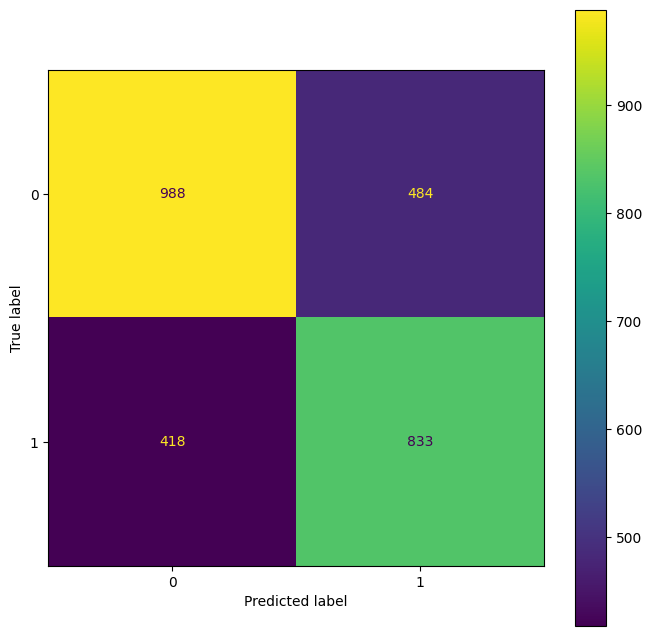

In [149]:
fig, ax = plt.subplots(figsize=(8, 8))
#plot_confusion_matrix(lr_clf, cls_test_features, cls_test_labels, ax=ax)
#print(dev_labels)  
plot_confusion_matrix(lr_clf, dev_cls, dev_labels, ax=ax)  
plt.show()

In [150]:
rel_labels = []
pos_embeddings = []
p = lr_clf.predict(dev_cls)
#print(len(p))
#print(len(classes))
#print(classes)

for elt in range(len(p)):
  if p[elt] ==1:
    pos_embeddings.append(cls_embeddings[elt])
    rel_labels.append(classes[elt])

cls_train_features, cls_test_features, cls_train_labels, cls_test_labels = train_test_split(pos_embeddings, rel_labels)

#Defines a logistic regression classifier
lr_clf = LogisticRegression(solver='saga', class_weight = 'balanced')

#Fits the model to the training data
lr_clf.fit(cls_train_features, cls_train_labels)

#Tests the model using the test data
lr_clf.score(cls_test_features, cls_test_labels)

print(classification_report(cls_test_labels, lr_clf.predict(cls_test_features)))


                        precision    recall  f1-score   support

             ACTIVATOR       0.00      0.00      0.00         9
               AGONIST       0.27      0.33      0.30        12
            ANTAGONIST       0.27      0.64      0.38        14
      DIRECT-REGULATOR       0.46      0.50      0.48        32
INDIRECT-DOWNREGULATOR       0.12      0.18      0.15        11
  INDIRECT-UPREGULATOR       0.21      0.43      0.29         7
             INHIBITOR       0.57      0.64      0.60        53
                  None       0.70      0.47      0.56       160
               PART-OF       0.27      0.67      0.38         6
            PRODUCT-OF       0.20      0.22      0.21         9
             SUBSTRATE       0.38      0.35      0.36        17

              accuracy                           0.47       330
             macro avg       0.31      0.40      0.34       330
          weighted avg       0.53      0.47      0.48       330



/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


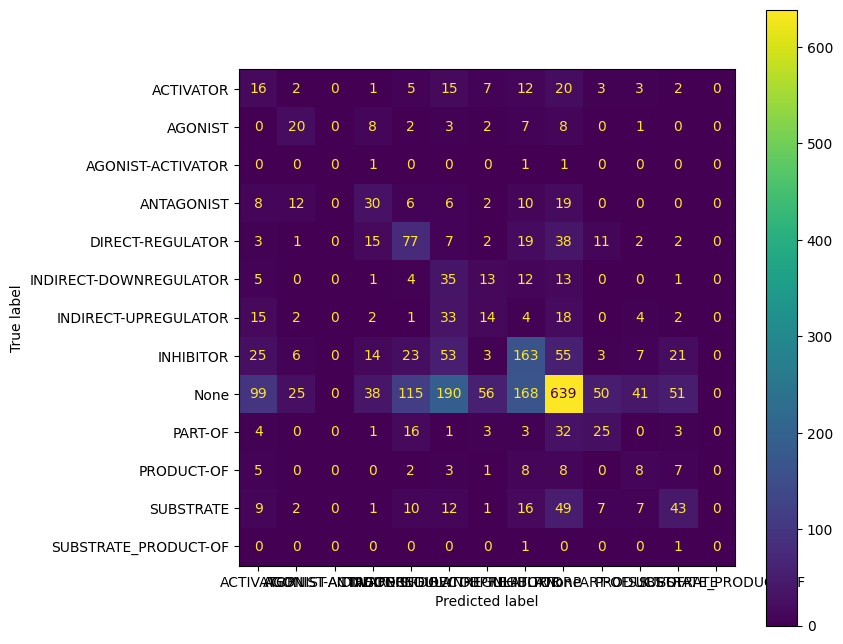

In [151]:
fig, ax = plt.subplots(figsize=(8, 8))
#plot_confusion_matrix(lr_clf, cls_test_features, cls_test_labels, ax=ax)
#print(dev_labels)  
plot_confusion_matrix(lr_clf, dev_cls, dev_classes, ax=ax)  
plt.show()

Entity start architecture

In [152]:
ent_labels = [doc['entity_labels'] for doc in docs if 'entity_labels' in doc.keys()]
dev_ent_labels = [d['entity_labels'] for d in dev_docs if 'entity_labels' in d.keys()]
#print(dev_ent_labels)
relation_labels = [doc['rel_labels'] for doc in docs if 'rel_labels' in doc.keys()]
dev_relation_labels = [d['rel_labels'] for d in dev_docs if 'rel_labels' in d.keys()]

#Entity and relation labels for the training set
e = list(itertools.chain.from_iterable(ent_labels))
dev_e = list(itertools.chain.from_iterable(dev_ent_labels))

#Entity and relation labels for the development set
r = list(itertools.chain.from_iterable(relation_labels))
dev_r = list(itertools.chain.from_iterable(dev_relation_labels))

#Ensuring these values are the same size
print(len(e))
print(len(r))

print()
print(len(dev_e))
print(len(dev_r))
#start_train_features, start_test_features, start_train_labels, start_test_labels = train_test_split(entity_embeddings, e[:64653])

64685
64685

13396
13396


In [153]:
lr_clf = LogisticRegression(solver='saga', class_weight ='balanced')
#lr_clf.fit(start_train_features, start_train_labels)
lr_clf.fit(entity_embeddings, e[:64653])
lr_clf.score(dev_ent, dev_e[:13392])

#print(classification_report(start_test_labels, lr_clf.predict(start_test_features)))
print(classification_report(dev_e[:13392], lr_clf.predict(dev_ent)))

              precision    recall  f1-score   support

           0       0.76      0.55      0.64      9664
           1       0.32      0.55      0.41      3728

    accuracy                           0.55     13392
   macro avg       0.54      0.55      0.52     13392
weighted avg       0.64      0.55      0.57     13392



/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


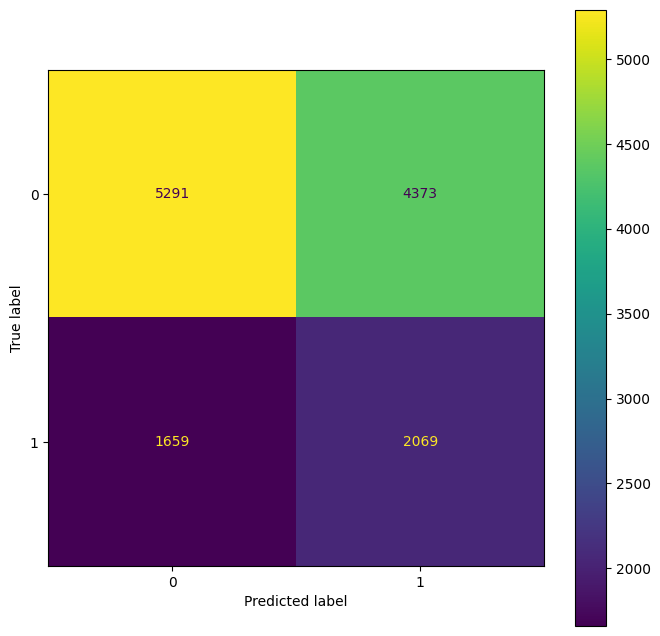

In [154]:
fig, ax = plt.subplots(figsize=(8, 8))
#plot_confusion_matrix(lr_clf, start_test_features, start_test_labels, ax=ax)  
plot_confusion_matrix(lr_clf, dev_ent, dev_e[:13392], ax=ax) 
plt.show()

In [155]:
rel_labels = []
pos_embeddings = []
p = lr_clf.predict(dev_ent)
for elt in range(len(p)):
  if p[elt] ==1:
    pos_embeddings.append(entity_embeddings[elt])
    if r[elt] == 0:
      rel_labels.append('NO_RELATION')
    else:
      rel_labels.append(r[elt])

start_train_features, start_test_features, start_train_labels, start_test_labels = train_test_split(pos_embeddings, rel_labels)

#Defines a logistic regression classifier
lr_clf = LogisticRegression(solver='saga')

#Fits the model to the training data
lr_clf.fit(start_train_features, start_train_labels)

#Tests the model using the test data
lr_clf.score(start_test_features, start_test_labels)

print(classification_report(start_test_labels, lr_clf.predict(start_test_features)))

                        precision    recall  f1-score   support

             ACTIVATOR       0.40      0.06      0.11        31
               AGONIST       0.00      0.00      0.00        31
     AGONIST-ACTIVATOR       0.00      0.00      0.00         2
            ANTAGONIST       0.50      0.11      0.18        47
      DIRECT-REGULATOR       0.33      0.13      0.19       100
INDIRECT-DOWNREGULATOR       0.40      0.07      0.12        28
  INDIRECT-UPREGULATOR       0.40      0.08      0.14        24
             INHIBITOR       0.29      0.10      0.15       159
           NO_RELATION       0.71      0.94      0.81      1109
               PART-OF       0.43      0.12      0.19        25
            PRODUCT-OF       0.67      0.11      0.18        19
             SUBSTRATE       0.00      0.00      0.00        36

              accuracy                           0.68      1611
             macro avg       0.34      0.14      0.17      1611
          weighted avg       0.59     

/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-define

/opt/conda/envs/sharedpy38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


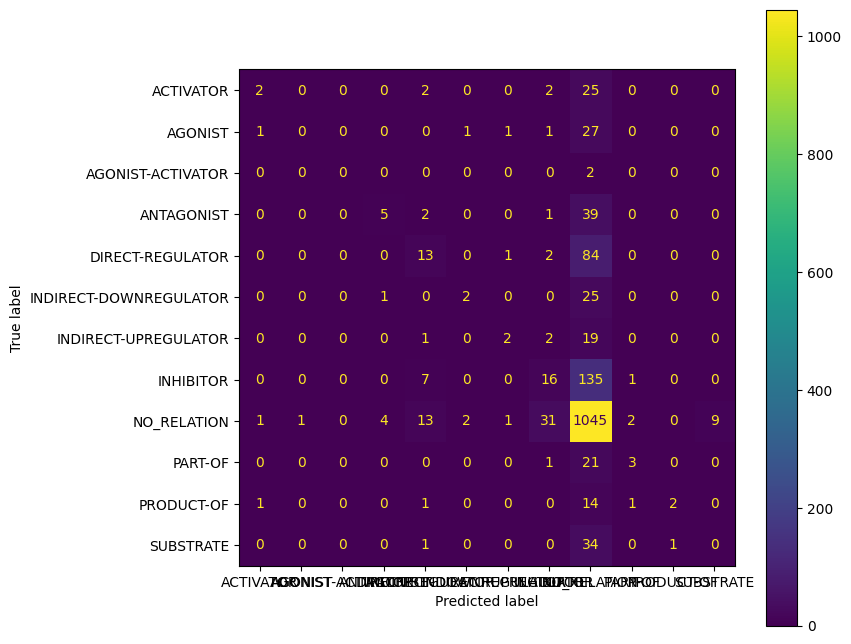

In [156]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lr_clf, start_test_features, start_test_labels, ax=ax)  
plt.show()